# **Welcome to Modelling Notebook :-)**

#**Importing Important Libraries**

In [ ]:
#Importing important libraries
import warnings 
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
import joblib
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing 

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 4.1 MB/s 


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

# **Importing Dataset**

Let's first import our dataset! :-)

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1KhBS2rVwN0oUGUTpAjNjHuvllmOvEwPh/view?usp=sharing'
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dfCleaned2.csv') 
 
df = pd.read_csv('dfCleaned2.csv', index_col=[0])
df['description'] = df['description'].apply(str) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30304 entries, 148 to 52477
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bookId                30304 non-null  object 
 1   title                 30304 non-null  object 
 2   rating                30304 non-null  float64
 3   description           30304 non-null  object 
 4   genres                30304 non-null  object 
 5   pages                 29545 non-null  float64
 6   numRatings            30304 non-null  int64  
 7   coverImg              30304 non-null  object 
 8   fiction               30304 non-null  int64  
 9   fantasy               30304 non-null  int64  
 10  romance               30304 non-null  int64  
 11  young adult           30304 non-null  int64  
 12  contemporary          30304 non-null  int64  
 13  adult                 30304 non-null  int64  
 14  nonfiction            30304 non-null  int64  
 15  history          

In [ ]:
top30genrelist = ['fiction',
'fantasy',
'romance',
'young adult',
'contemporary',
'adult',
'nonfiction',
'history',
'novels',
'mystery',
'historical fiction',
'audiobook',
'science fiction',
'paranormal',
'literature',
'adventure',
'classics',
'thriller',
'childrens',
'magic',
'humor',
'contemporary romance',
'crime',
'suspense',
'middle grade',
'chick lit',
'biography',
'teen',
'horror',
'philosophy']

From the previous EDA analysis, we will only be keeping the `Brightness` and `numRating` for numerical values, therefore, we will remove `pages` and `ratings` from the dataframe.

In [ ]:
df.drop(['pages', 'rating'], axis = 1, inplace = True)

# **Helper Functions**

In [ ]:
def accuracy(y_actual, y_predict):
    '''
    Returns classification report as a data frame
    '''
    result = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Support'])
    tp, fp, fn, total = 0, 0, 0, 0
    if not isinstance(y_predict, pd.DataFrame):
        y_predict = pd.DataFrame(y_predict, columns=y_actual.columns)
    for col in y_actual.columns:
        support = y_actual[col].sum()
        tp = ((y_actual[col]==1) & (y_predict[col]==1)).sum()
        fp = ((y_actual[col]==0) & (y_predict[col]==1)).sum()
        fn = ((y_actual[col]==1) & (y_predict[col]==0)).sum()
        
        precision = 0 if (tp+fp==0) else tp/(tp+fp)
        recall = 0 if (tp+fn==0) else tp/(tp+fn)
        f1_score = 0 if (precision==0 and recall==0) else 2*precision*recall/(precision+recall)
        
        result.loc[col] = [precision, recall, f1_score, support]
    
    avg_precision = (result['Precision']*result['Support']).sum()/result['Support'].sum()
    avg_recall = (result['Recall']*result['Support']).sum()/result['Support'].sum()
    avg_f1_score = (result['F1-Score']*result['Support']).sum()/result['Support'].sum()
    result.loc['Avg/Total'] = [avg_precision, avg_recall, avg_f1_score, result['Support'].sum()]
    
    return round(result, 2)

def overall_f1_score_v1(y_actual, y_predict):
    '''
    Overall F1 Score. Used as our final evaluation metric 
    v1: Used for Binary Relevance. 
    y_actual and y_predict have dimensions n_rows x num_genres
    '''
    num_genres = y_actual.shape[1]
    tp, fp, fn = 0, 0, 0
    for idx in range(num_genres):
        tp+=((y_actual.iloc[:,idx]==1) & (y_predict[:,idx]==1)).sum()
        fp+=((y_actual.iloc[:,idx]==0) & (y_predict[:,idx]==1)).sum()
        fn+=((y_actual.iloc[:,idx]==1) & (y_predict[:,idx]==0)).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

def overall_f1_score_v2(y_actual, y_predict, class_to_genre_map=None):
    '''
    Overall F1 Score. Used as our final evaluation metric 
    v2: Used for Label Powerset
    Here y_actual and y_predict have dimensions of n_rows x 1. 
    Prediction for each row would be a label whose mapping to respective genre
    combination is provided in class_to_genre_map
    '''
    num_class, num_genres = class_to_genre_map.shape[0], class_to_genre_map.shape[1]
    
    y_actual_matrix = np.empty((y_actual.shape[0], num_genres))
    y_predict_matrix = np.empty((y_actual.shape[0], num_genres))
    
    
    for idx in range(num_class):
        if idx in y_predict:
            y_predict_matrix[y_predict==idx,:] = class_to_genre_map.loc[idx,:].values
        if idx in y_actual:
            y_actual_matrix[y_actual==idx,:] = class_to_genre_map.loc[idx,:].values 
    
    tp, fp, fn = 0, 0, 0
    for idx in range(num_genres):
        tp+=((y_actual_matrix[:,idx]==1) & (y_predict_matrix[:,idx]==1)).sum()
        fp+=((y_actual_matrix[:,idx]==0) & (y_predict_matrix[:,idx]==1)).sum()
        fn+=((y_actual_matrix[:,idx]==1) & (y_predict_matrix[:,idx]==0)).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

def multi_class_predict(clf, X_test, class_to_genre_map):
    '''
    Multi-label prediction based on Label Powerset
    Predictions made by classifiers are labels ranging from 0 to num_class
    class_to_genre_map maps the labels to genre combination
    '''
    if isinstance(X_test, pd.Series):
        y_pred = pd.DataFrame(index=X_test.index, columns=class_to_genre_map.columns)
    else:
        y_pred = pd.DataFrame(index=range(X_test.shape[0]), columns=class_to_genre_map.columns)
    
    num_class = class_to_genre_map.shape[0]
    y_class = clf.predict(X_test)
    for idx in range(num_class):
        if idx in y_class:
            y_pred.loc[y_class==idx,:] = class_to_genre_map.loc[idx,:].values
    return y_pred

# **Train / Test Split**

As previously found when analysing the genres:
*  The Lowest genre is "philosophy" with **1582** books
*   Compared to the Highest genre of "fiction" with **21590** books 

We thus have a multi-label data set with highly imbalanced labels.

A regular test-split as learnt in the lab sessions may thus not be accurate for our scenario as traditional single-label approaches to stratifying data fail to provide balanced data set divisions.

We hence utilise `skmultilearn` iterative train test split instead utilising `Iterative Stratification` which optimises cross validators to ensure we can stratify multilabel data

Every genre can therefore be ensured a `minimum fraction` (~0.25 to 0.3) during the split for a balanced division.



---
The following diagram shows the algorithm:

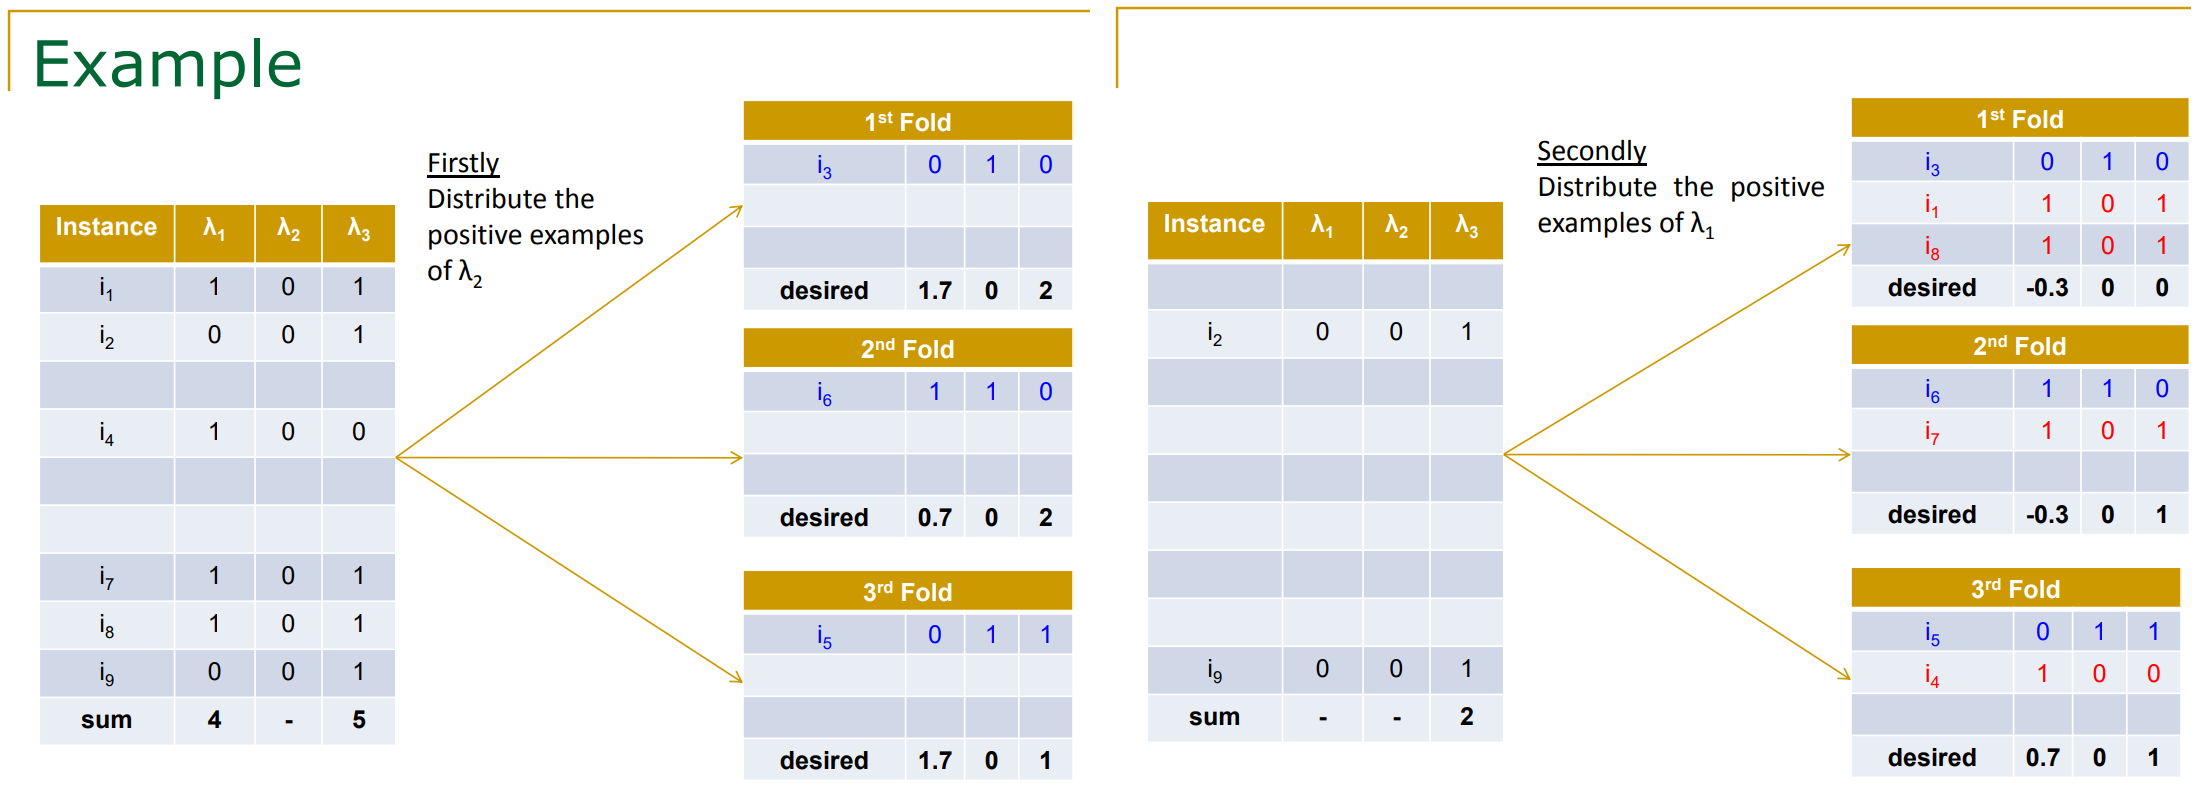

>* The algorithm selects the label with the fewest remaining examples
 * If rare labels are not examined in priority, they may be
distributed in an undesired way, beyond subsequent repair
* For frequent labels, we have the chance to modify the
current distribution towards the desired one in a subsequent
iteration, due to the availability of more examples

Let's Start with splitting our independent and target variables:

In [ ]:
# Split the data into our X and y where X are the independent variables (everything except the genres), and y holds our target variables (just the genres).
# X (Brightness, numRatings, Description) and y (Genres)
X = df[['brightness','numRatings', 'description']]
y = df[top30genrelist]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30304 entries, 148 to 52477
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   brightness   30304 non-null  float64
 1   numRatings   30304 non-null  int64  
 2   description  30304 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 947.0+ KB


X and y must be converted to np array before inputting into the function to prevent keyErrors

In [ ]:
# Converting X and y to numpy arrays
Xnp = X.to_numpy()
ynp = y.to_numpy()

In [ ]:
# Split the independent and target variables into 70/30 Train-Test split
X_train, y_train, X_test, y_test = iterative_train_test_split(Xnp, ynp, test_size = 0.3)

In [ ]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(X_test.shape[0]/Xnp.shape[0]))

Fraction of data in the Training Data Set: 0.301


In [ ]:
# Convert the numpy array back to a dataframe so that we can later vectorize it
df_X_train = pd.DataFrame(X_train, columns = ['brightness','numRatings','description'])
df_X_test = pd.DataFrame(X_test, columns = ['brightness','numRatings','description'])
df_y_train = pd.DataFrame(y_train, columns = [top30genrelist])
df_y_test = pd.DataFrame(y_test, columns = [top30genrelist])

In [ ]:
# from google.colab import files
# df_y_train.to_csv('df_y_train.csv') 
# files.download('df_y_train.csv')

# df_y_test.to_csv('df_y_test.csv') 
# files.download('df_y_test.csv')

# df_X_train.to_csv('df_X_train.csv') 
# files.download('df_X_train.csv')

# df_X_test.to_csv('df_X_test.csv') 
# files.download('df_X_test.csv')

In [ ]:
totalG = y[top30genrelist].sum()
totalGTrain = df_y_train[top30genrelist].sum()
totalGTest = df_y_test[top30genrelist].sum()
GTrain = pd.DataFrame({'Genre': top30genrelist, 'Total': totalGTrain.values/totalG.values, 'Data Set': 'Train'})
GTest = pd.DataFrame({'Genre': top30genrelist, 'Total': totalGTest.values/totalG.values, 'Data Set': 'Test'})
GTrainTest = pd.concat([GTrain, GTest])

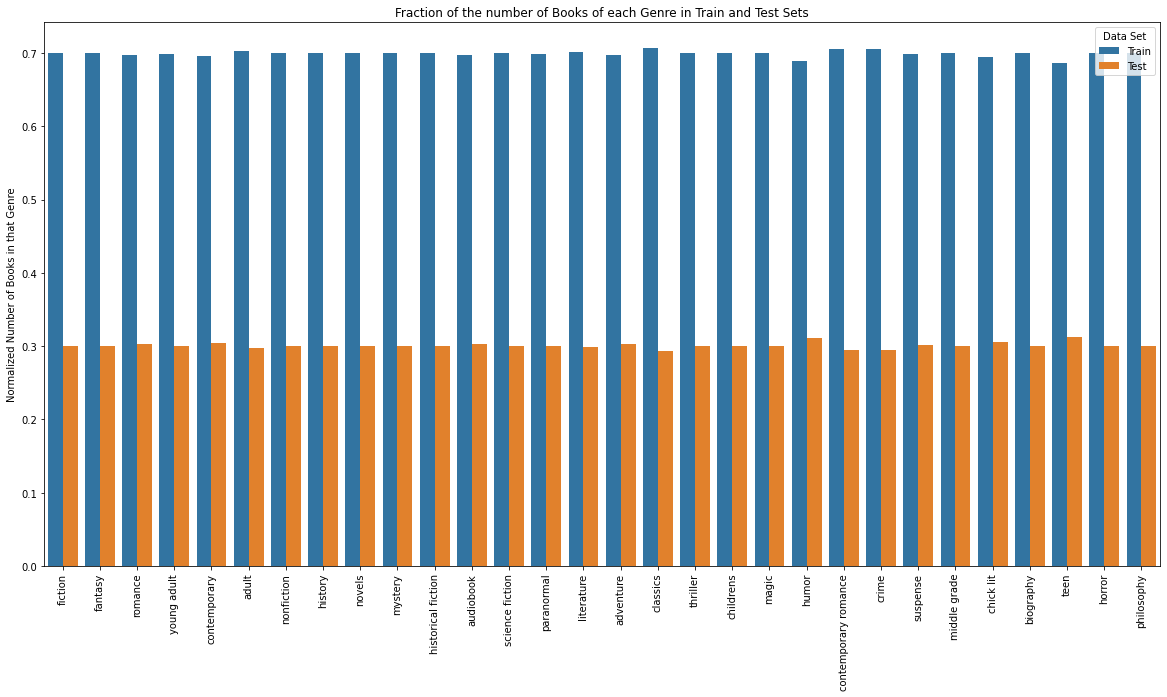

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=GTrainTest, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Books in that Genre', xlabel='')
ax.set(title='Fraction of the number of Books of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

**Observation from Train/Test Split plot**

Examining the train test composition, we notice that for every category, we have at least 70% of the samples in the training data set and at least 30% of the samples in the test data set.

The number of occurences of each category may be slightly greater than the `sample_distribution_per_fold` due to books overlapping between genres. 

The variance however is satisfactory and iterative stratification works as intended for the large labelsets.

# **Vectorizing** 

> Why Vectorize?

We included description as one of our variables in predicting the genre of the books. Since we cannot work with raw words in machine learning models, we have to first vectorize our dataset. 

We do so by through the use of **Text Encoding** which converts the textual data to numeric vectors that we can put into our machine learning models.


> Considered Vectorizers:

There are a few text encoders such as `Word Count with Counter Vectorizer`, `TF-IDF Vectorizer` and `Google Universal Sentence Encoder`. 

For `Google Universal Sentence Encoder`, it requires high memory and computational time with its transformer model architecture.
`Count Vectorizer` on the other hand merely returns the count of the words in the document.

Thus we settled on `TF-IDF` as it is better able to measure the weight of a word across documents giving us more insight. 

> Whats TF-IDF?:

**TF-IDF Vectorizer** looks at the Inverse Word Frequencies in the books' descriptions. 

*   The inverse document frequency **(IDF)** of the word is done across a set of documents. If the word is very common and appears in many documents, this number will approach 0 and deemed unimportant to predicting the genre. Otherwise, it will approach 1. 
*  The term frequency is the frequency of word in the document **(TF)** often done via the raw count.
*  Multiplying these two metrics, TF and IDF, results in the TF-IDF score of a word in a document. Thus, the higher the score, the more relevant that word is in the document.

In [ ]:
# min_df defines the number of time the word should appear in the description
# for it to be included in the dataset. 
tfidf = TfidfVectorizer(stop_words = ['world', 'life'], min_df = 20)

# Fitting the vectorizer to the training data set
# Fit learns the vocabulary and idf from the training set. We should not apply 
# it to the test set as it will make our output overly optimistic.
tfidf.fit(df_X_train['description'])

# Transform both train and test data sets into vectorized form
X_train_tfidf = tfidf.transform(df_X_train['description'])
X_test_tfidf = tfidf.transform(df_X_test['description']) 

In [ ]:
# Array mapping from feature integer indices to feature name.
pd.DataFrame(tfidf.get_feature_names()).sample(30)

,0
1347,connie
1220,colleagues
5735,roarke
1376,consume
4598,nobel
5941,seat
2871,goods
1101,choices
6094,short
6193,sleazy


In [ ]:
# Change the numpy array into a dataframe
X_train_transformed_df = pd.DataFrame(X_train_tfidf.toarray(), index=df_X_train.index, columns=tfidf.get_feature_names()) 
X_test_transformed_df = pd.DataFrame(X_test_tfidf.toarray(), index=df_X_test.index, columns=tfidf.get_feature_names()) 
X_train_transformed_df

,aaron,abandon,abandonment,abbey,abby,abbys,abduct,abduction,abide,abigail,...,youtube,youve,zane,zen,zeus,zoe,zombie,zombies,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create final X_train and X_test dataframe that contains numeric columns together with the vectorized descriptions.
X_train_transformed_df_full = pd.concat([df_X_train, X_train_transformed_df],axis=1)
X_test_transformed_df_full = pd.concat([df_X_test, X_test_transformed_df],axis=1)
X_train_transformed_df_full

,brightness,numRatings,description,aaron,abandon,abandonment,abbey,abby,abbys,abduct,...,youtube,youve,zane,zen,zeus,zoe,zombie,zombies,zone,zoo
0,118.689835,4260,raise like sisters mariamne salome indulge ric...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.488519,2053,houdini heart harken back master suspenseful s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,207.0,9170,sequel quantum root meekish olan chapman face ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,234.0,5171,match configurations second sequel quantum roo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70.310575,20586,jorge luis borges call greatest spanish langua...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21177,10.242412,871,fateful trilogy continue fracture call fractur...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21178,2.086145,37,anasazi sequel thirteenth chime emma michaels ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21179,9.588118,6674,readers favorite award winner sixteen year old...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21180,26.123706,238,powerful tremor unearth ancient secretburied n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Download the train/test split because iterative splitting has no option to seed. Therefore, we download the same dataset for the purpose of ensuring everytime we run we get the same random set of train-test split

In [ ]:
# from google.colab import files
# X_train_transformed_df_full.to_csv('X_vectorizedtrain.csv') 
# files.download('X_vectorizedtrain.csv')
# X_test_transformed_df_full.to_csv('X_vectorizedtest.csv') 
# files.download('X_vectorizedtest.csv')

# **Reimport the Vectorized Data Set**

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link1 = 'https://drive.google.com/file/d/1D7gaeHi99FFOFiNG8MV6_w08pMshdV1M/view?usp=sharing'
link2 = 'https://drive.google.com/file/d/1HW8qsdVs6Q8pEBfCz1bgjN8SYPILBWvl/view?usp=sharing'
link3 = 'https://drive.google.com/file/d/1Vxfym9xJT2cIOD3WPmid6NUQDDlXHNJ8/view?usp=sharing'
link4 = 'https://drive.google.com/file/d/1ld-jhZCMeOhPzOgiJ2ErMOb3qTnr7S4p/view?usp=sharing'
link5 = 'https://drive.google.com/file/d/1X6qgKACOUCYFoV_0jcTtssOdzDvfJD-G/view?usp=sharing'
link6 = 'https://drive.google.com/file/d/1xTK0ixrKdBD6CdZSq-Kdm4a1WQB7S8YT/view?usp=sharing' 
# to get the id part of the file
id1 = link1.split("/")[-2]
id2 = link2.split("/")[-2]
id3 = link3.split("/")[-2]
id4 = link4.split("/")[-2]
id5 = link5.split("/")[-2]
id6 = link6.split("/")[-2]
  
downloaded1 = drive.CreateFile({'id':id1})
downloaded1.GetContentFile('df_X_train.csv') 
df_X_train = pd.read_csv('df_X_train.csv', index_col=[0])

downloaded2 = drive.CreateFile({'id':id2})
downloaded2.GetContentFile('df_X_test.csv') 
df_X_test = pd.read_csv('df_X_test.csv', index_col=[0])

downloaded3 = drive.CreateFile({'id':id3})
downloaded3.GetContentFile('df_y_train.csv') 
y_train = pd.read_csv('df_y_train.csv', index_col=[0])

downloaded4 = drive.CreateFile({'id':id4})
downloaded4.GetContentFile('df_y_test.csv') 
y_test = pd.read_csv('df_y_test.csv', index_col=[0])

downloaded5 = drive.CreateFile({'id':id5})
downloaded5.GetContentFile('X_vectorizedTrain.csv') 
df_X_vectorized_train = pd.read_csv('X_vectorizedTrain.csv', index_col=[0])

downloaded6 = drive.CreateFile({'id':id6})
downloaded6.GetContentFile('X_vectorizedTest.csv') 
df_X_vectorized_test = pd.read_csv('X_vectorizedTest.csv', index_col=[0])

# **Scaling**

We scale our data because for many machine learning algorithms are sensitive to data scales.

For algorithms such as logistic regression, neural network, etc. that use gradient descent as an optimization technique, scaling helps the gradient descent converge more quickly towards the minima 

For Distance algorithms like SVM which uses distances between data points to determine their similarity, higher weightage is given to features with higher magnitude.

*   `StandardScaler` removes the mean and scales the data to unit variance. The scaling shrinks the range of the feature values as shown in the left figure below. However, the outliers have an influence when computing the empirical mean and standard deviation.
*   `MinMaxScaler` rescales the data set such that all feature values are in the range [0, 1] as shown in the right panel below. However, this scaling compresses all inliers into the narrow range [0, 0.005] for the transformed average house occupancy.
* `RobustScaler` Unlike the previous scalers, the centering and scaling statistics of RobustScaler is based on percentiles and are therefore not influenced by a few number of very large marginal outliers. 

We will use either MinMax or Standard Scaler as we find that outliers are certainly useful in our prediction. However, we chose MinMax in the end because it scales from [0,1] which ensures no negative values are returned when passing it into the various machine learning algorithms (e.g Naive Bayes)

In [ ]:
# scaler1 = preprocessing.RobustScaler()
# X_train_rb = scaler1.fit_transform(df_X_vectorized_train)
# X_test_rb = scaler1.fit_transform(df_X_vectorized_test)
 
# scaler2 = preprocessing.StandardScaler()
# X_train_s = scaler2.fit_transform(df_X_vectorized_train)
# X_test_s = scaler2.fit_transform(df_X_vectorized_test)
df_X_vectorized_train.drop("description", axis = 1, inplace = True)
df_X_vectorized_test.drop("description", axis = 1, inplace = True)

scaler3 = preprocessing.MinMaxScaler()
X_train_mm = scaler3.fit_transform(df_X_vectorized_train)
X_test_mm = scaler3.fit_transform(df_X_vectorized_test)

# **Classification Models** 

The Machine Learning modeling algorithms that we will be using include: `Logistic Regression`, `Naive Bayes` and `Linear Support Vector Machine Classifier`.

We will be pushing our data set into the models and analysing which models returns the best F1-Score & Exact Accuracy.

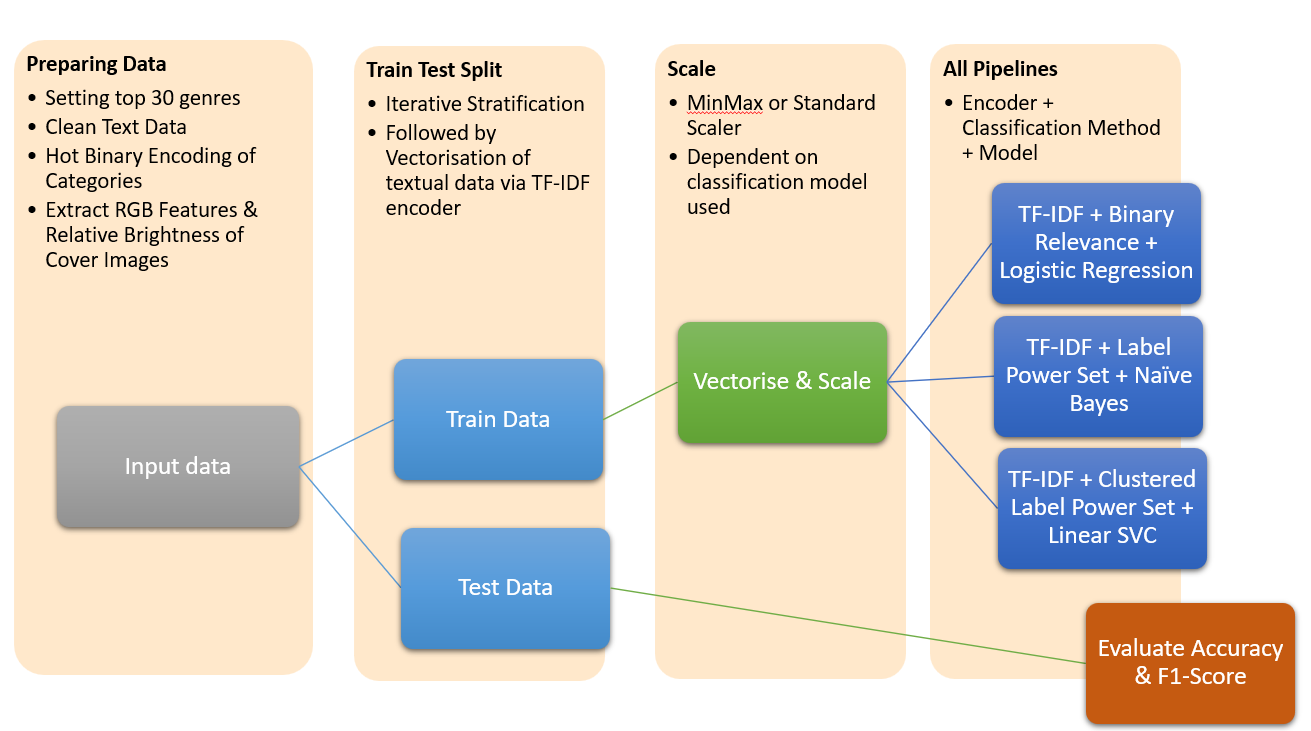

**Multilabel Classification Algorithms**
1.   **Binary Relevance** | is a multi-label classification algorithm, which treats each genre as a separate Single Class Classification Problem. `OneVsRestClassifier` was used to achieve this.

2.   **Label Powerset** | takes partial correlations between genres. Matrix is transformed to n_row*1 single label vectors whose column vector ranges from 0 to the number of unique genre combinations. Classifier is then trained on the transformed vectors with a classifier. Transform vectors back to genres again and predict.

3.   **Label Powerset with Clustering** | utilises `K-means`. cluster_center represents the mean of that genre combination.




For all our model, they cannot be used for multi-class classification tasks directly because they are designed for binary classification problems.

Therefore, heuristic method is required to split a multi-class classification problem into multiple binary classification datasets and train a binary classification model each.

One of these heuristic methods include the **One-VS-Rest method**.

Therefore, we will be using the **One-VS-Rest method** when applying the following models:

- Logistic Regression
- Naives Bayes
- Linear SVC


**To Evaluate the Pipelines**
* we will utilise the `F1-Score`: 

*   `precision` = correctly identified genre X books / total identified genre X books
*   `recall` = correctly identified genre X books / total genre X books




## **Logistic Regression**
Logistic Regression is used in statistical software to understand the relationship between the dependent variable and one or more independent variables by estimating probabilities using a logistic regression equation. 


This type of analysis can help us predict the likelihood of a book being in a particular genre being made.

In [ ]:
# Fitting the Logistic Regression model onto our dataset
LRmodel = OneVsRestClassifier(LogisticRegression(random_state=123, solver='lbfgs', max_iter=3000, C=0.01, n_jobs=-1), n_jobs=-1).fit(X_train_mm, y_train)


In [ ]:
# Use the fitted model to predict the genres 
y_train_pred = LRmodel.predict(X_train_mm)
y_train_proba = LRmodel.predict_proba(X_train_mm)
y_test_pred = LRmodel.predict(X_test_mm)
y_test_proba =LRmodel.predict_proba(X_test_mm)

In [ ]:
# Print out the accuracy score for our train data set 
resultTrain = accuracy(y_train, y_train_pred)
resultTrain

,Precision,Recall,F1-Score,Support
fiction,0.75,1.00,0.86,15113.0
fantasy,0.92,0.45,0.60,7486.0
romance,0.90,0.51,0.65,7564.0
young adult,0.88,0.22,0.35,6454.0
contemporary,0.91,0.11,0.19,4937.0
adult,0.84,0.03,0.06,4837.0
nonfiction,0.91,0.20,0.33,5077.0
history,0.88,0.20,0.32,6596.0
novels,0.00,0.00,0.00,4486.0
mystery,0.98,0.03,0.05,3771.0


In [ ]:
# Print out the accuracy score for our test data set 
resultTest = accuracy(y_test, y_test_pred)
resultTest

,Precision,Recall,F1-Score,Support
fiction,0.75,1.00,0.86,6477.0
fantasy,0.91,0.49,0.63,3208.0
romance,0.85,0.56,0.67,3298.0
young adult,0.83,0.28,0.42,2774.0
contemporary,0.85,0.16,0.26,2157.0
adult,0.82,0.07,0.13,2039.0
nonfiction,0.92,0.24,0.39,2176.0
history,0.83,0.22,0.34,2827.0
novels,1.00,0.00,0.00,1922.0
mystery,0.98,0.05,0.10,1616.0


## **Naive Bayes**
Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. 

A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
train_y_cluster_labels= y_train.groupby(list(top30genrelist)).ngroup()
cluster_center = y_train.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

Naive Bayes cannot accept negative values from X. As such instead of using the standard scaler, we use MinMax instead.

In [ ]:
# We have already vectorized our dataset in the earlier segment, so we only have to use the MultinomialNB model
NBmodel = Pipeline([
                ('clf', MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None))
            ])
NBmodel.fit(X_train_mm, train_y_cluster_labels)
NBpredictions = multi_class_predict(NBmodel, X_test_mm, cluster_center) 
accuracy(y_test, NBpredictions)


,Precision,Recall,F1-Score,Support
fiction,0.82,0.62,0.71,6477.0
fantasy,0.83,0.42,0.55,3208.0
romance,0.72,0.55,0.62,3298.0
young adult,0.70,0.43,0.53,2774.0
contemporary,0.67,0.27,0.39,2157.0
adult,0.32,0.47,0.38,2039.0
nonfiction,0.47,0.79,0.59,2176.0
history,0.45,0.80,0.57,2827.0
novels,0.30,0.38,0.34,1922.0
mystery,0.72,0.14,0.24,1616.0


## **Linear Support Vector Machine Classifier**

### **K-Means Clustering**


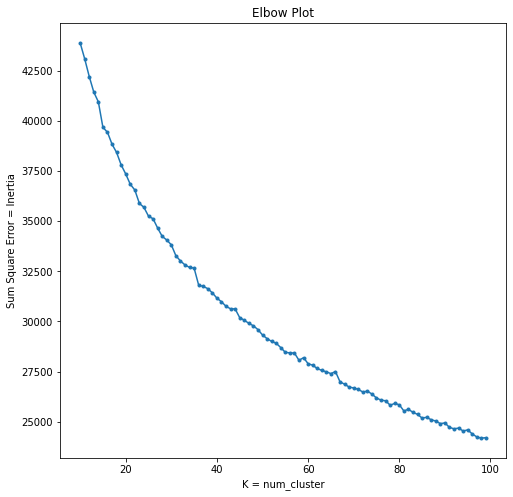

In [ ]:
ss = [];
ks = range(10, 100)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(y_train)
    ss.append(kmeans.inertia_)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, ss, marker='.')
axes.set(xlabel='K = num_cluster', ylabel = 'Sum Square Error = Inertia', title = 'Elbow Plot')
plt.show()

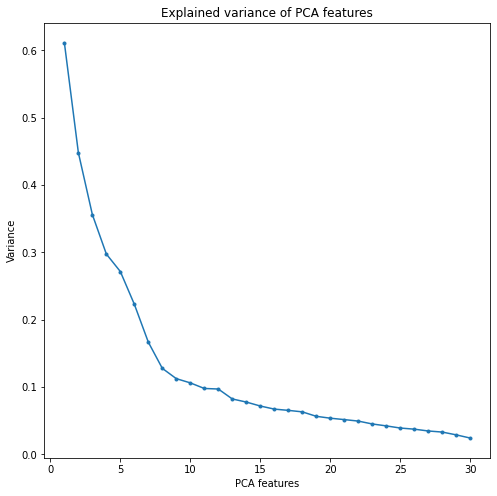

In [ ]:
pca = PCA()
pca.fit(y_train)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(range(1, pca.n_components_+1), pca.explained_variance_, marker = '.')
axes.set(xlabel = 'PCA features', ylabel='Variance', title='Explained variance of PCA features')
plt.show()

In [ ]:
print('Number of unique labels = ', y_train.drop_duplicates().shape[0])

Number of unique labels =  6436


In [ ]:
ks = [50, 60, 65, 70, 75, 90, 100]
f1_score = []
thresh = 0.85
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(y_train)
    cluster_center = pd.DataFrame(columns=y_train.columns)
    for cluster_id in range(k):
        cluster_center.loc[cluster_id] = (kmeans.cluster_centers_[cluster_id]>=thresh)*1

    for idx, col in enumerate(y_train.columns):
        max_idx = kmeans.cluster_centers_[:,idx].argmax()
        max_value = kmeans.cluster_centers_[:,idx].max()
        if max_value<thresh:
            cluster_center.loc[max_idx, col] = 1
    
    y_pred = pd.DataFrame(columns=y_train.columns, index=y_train.index)
    for idx in range(k):
        y_pred.loc[labels==idx,:] = cluster_center.loc[idx,:].values

    result = accuracy(y_train, y_pred)
    f1_score.append(result.loc['Avg/Total', 'F1-Score'])


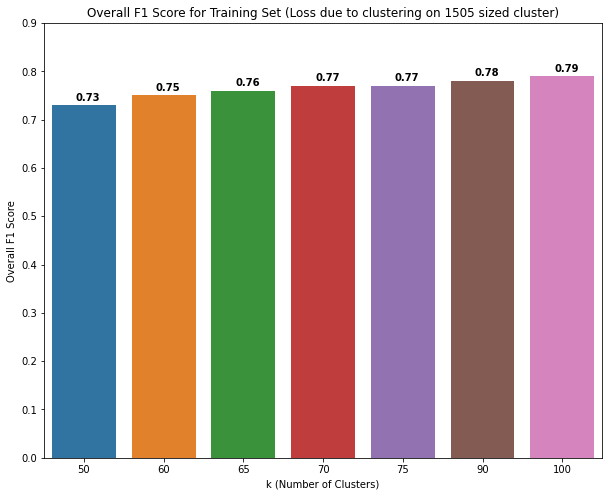

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(x=ks, y=f1_score, axes=ax)
ax.set(ylabel='Overall F1 Score', xlabel='k (Number of Clusters)')
ax.set(title='Overall F1 Score for Training Set (Loss due to clustering on 1505 sized cluster)')
plt.yticks(list(np.arange(0, 1, 0.1)))
for idx, val in enumerate(f1_score):
    ax.text(idx-0.1, val + 0.01,  str(val), color='black', fontweight='bold')
plt.show()

In [ ]:
train_y_cluster_labels= y_train.groupby(list(top30genrelist)).ngroup()
cluster_center = y_train.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

* *The Error can be ignored, it was resolved*:
* The classifier `best_clf` still ran

In [ ]:
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(SVC(),  param_grid={'C': [5, 20, 50, 100]}, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(X_train_mm, train_y_cluster_labels)

print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, X_test_mm, cluster_center) 
accuracy(y_train, predictions)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START C=5.........................................................
[CV 1/2; 1/4] END ..........................C=5;, score=0.820 total time=99.6min
[CV 2/2; 1/4] START C=5.........................................................
[CV 2/2; 1/4] END .........................C=5;, score=0.257 total time=101.3min
[CV 1/2; 2/4] START C=20........................................................
[CV 1/2; 2/4] END .........................C=20;, score=0.820 total time=99.8min
[CV 2/2; 2/4] START C=20........................................................
[CV 2/2; 2/4] END .........................C=20;, score=0.257 total time=97.2min
[CV 1/2; 3/4] START C=50........................................................
[CV 1/2; 3/4] END .........................C=50;, score=0.820 total time=91.8min
[CV 2/2; 3/4] START C=50........................................................
[CV 2/2; 3/4] END .........................C=50;, 

AttributeError: 'SVC' object has no attribute 'steps'

In [ ]:
print(grid_search_cv)

GridSearchCV(cv=2, estimator=SVC(), param_grid={'C': [5, 20, 50, 100]},
             scoring=make_scorer(overall_f1_score_v2, class_to_genre_map=        fiction  fantasy  romance  young adult  contemporary  adult  \
Labels                                                                
0             0        0        0            0             0      0   
1             0        0        0            0             0      0   
2             0        0        0            0             0      0   
3             0        0        0            0             0      0   
4             0        0        0            0             0      0   
...         ...      ...      ...          ...           ...    ...   
6446          1        1        1            1             1      1   
6447          1        1        1            1             1      1   
6448          1        1        1            1             1      1   
6449          1        1        1            1             1      1   
645

In [ ]:
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, X_test_mm, cluster_center) 
accuracy(y_train, predictions)

Applying best classifier on test data:


,Precision,Recall,F1-Score,Support
fiction,0.72,0.72,0.72,15114.0
fantasy,0.39,0.33,0.35,7487.0
romance,0.37,0.35,0.36,7603.0
young adult,0.35,0.28,0.31,6460.0
contemporary,0.24,0.20,0.22,4938.0
adult,0.22,0.19,0.21,4839.0
nonfiction,0.24,0.23,0.24,5077.0
history,0.29,0.29,0.29,6597.0
novels,0.26,0.22,0.24,4486.0
mystery,0.19,0.11,0.14,3772.0
